In [121]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr1,28975111,28975251,unfragmented.fwd_peak_575,406557,7776.06055,40663.78516,40655.76562,7950.0,13,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
1,chr6,95156834,95156909,unfragmented.rvs_peak_21883,226391,4793.16650,22647.25391,22639.17383,5383.0,13,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
2,chr1,17067009,17067186,unfragmented.fwd_peak_340,115434,2533.84814,11550.93359,11543.46289,2635.0,13,RNU1-4,snRNA,+,RP5-1182A14.7,Long RNA,0.0,0.0,Sense
3,chr1,149223883,149224222,unfragmented.rvs_peak_1454,111122,2457.10229,11119.83008,11112.27832,2563.0,13,RNVU1-18,snRNA,-,.,Unannotated,0.0,0.0,Sense
4,chr1,17222473,17222648,unfragmented.fwd_peak_344,107924,2320.96216,10799.73438,10792.40625,2379.0,13,RNU1-2,snRNA,+,.,Unannotated,0.0,0.0,Sense


In [123]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'tRF3':'black',
     'tRF5':'black',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

peak_df\
        .assign(peak_count = 1)\
        .groupby(['sense_gtype', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('sense_gtype').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .query('sense_gtype == "Long RNA"')

In [124]:
peak_df\
    .query('pileup >= %i & sample_count > %i' %(pileup_cutoff, sample_cutoff))\
    .query('sense_gtype == "Long RNA"')\
    .sort_values('pileup', ascending=False)\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_mt = lambda d: d.seq.map(is_mt))

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,is_mt
11,chr9,35657742,35658018,unfragmented.rvs_peak_25444,52787,1239.07764,5285.51123,5278.75781,1283.0,13,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,CGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGAC...,not_MT
13,chr14,20811226,20811574,unfragmented.rvs_peak_7257,44763,1095.45557,4483.00537,4476.35010,1158.0,13,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TCCCATAGGGCGGAGGGAAGCTCATCAGTGGGGCCACGAGCTGAGT...,not_MT
23,chr2,140977935,140978004,unfragmented.rvs_peak_14162,15724,386.71091,1578.71606,1572.46533,391.0,12,AC092156.2,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTT...,not_MT
25,chr1,238105784,238105861,unfragmented.rvs_peak_2383,11987,304.58301,1204.97070,1198.79883,308.0,12,RP11-193H5.8,Long RNA,-,nmt-tRNA-Pro-TGG-1-1-tRF5,tRF5,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCAGGCCCATACCCCAAAACTG...,not_MT
30,chr16,20733602,20733724,unfragmented.rvs_peak_9353,10215,279.88235,1027.68311,1021.58997,287.0,13,THUMPD1,Long RNA,-,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT
36,chr7,63571925,63571997,unfragmented.rvs_peak_23074,8046,212.96291,810.70978,804.65820,215.0,13,RP11-3N2.6,Long RNA,-,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT
46,chr9,81357657,81357729,unfragmented.rvs_peak_25616,6096,165.73325,615.56097,609.61292,167.0,13,RP11-506C15.1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,GAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAATG...,not_MT
48,chr13,85095787,85095864,unfragmented.fwd_peak_7153,5967,162.76080,602.88049,596.76300,164.0,13,LINC00333,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TAATTTTTAAAGGATAAGACTTATCTGTTGGTCTTAGGAACCCAAA...,not_MT
53,chr9,5095156,5095229,unfragmented.fwd_peak_26065,5148,153.39864,520.90430,514.83673,157.0,13,JAK2,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT
51,chr4,156383810,156383887,unfragmented.rvs_peak_19449,5486,150.93564,554.50079,548.60199,152.0,11,RP11-627H22.4,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,GATTAAGGTCAGCTAAATAAGCTATTGGGCCCATACACCAAAAATG...,not_MT


In [125]:
peak_df.sense_gtype.unique()

array(['snRNA', 'RBP', 'Unannotated', 'Long RNA', 'misc RNA', 'snoRNA',
       'Repeats', 'miRNA', 'piRNA', 'tRF5', 'tRF3'], dtype=object)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_figure.pdf


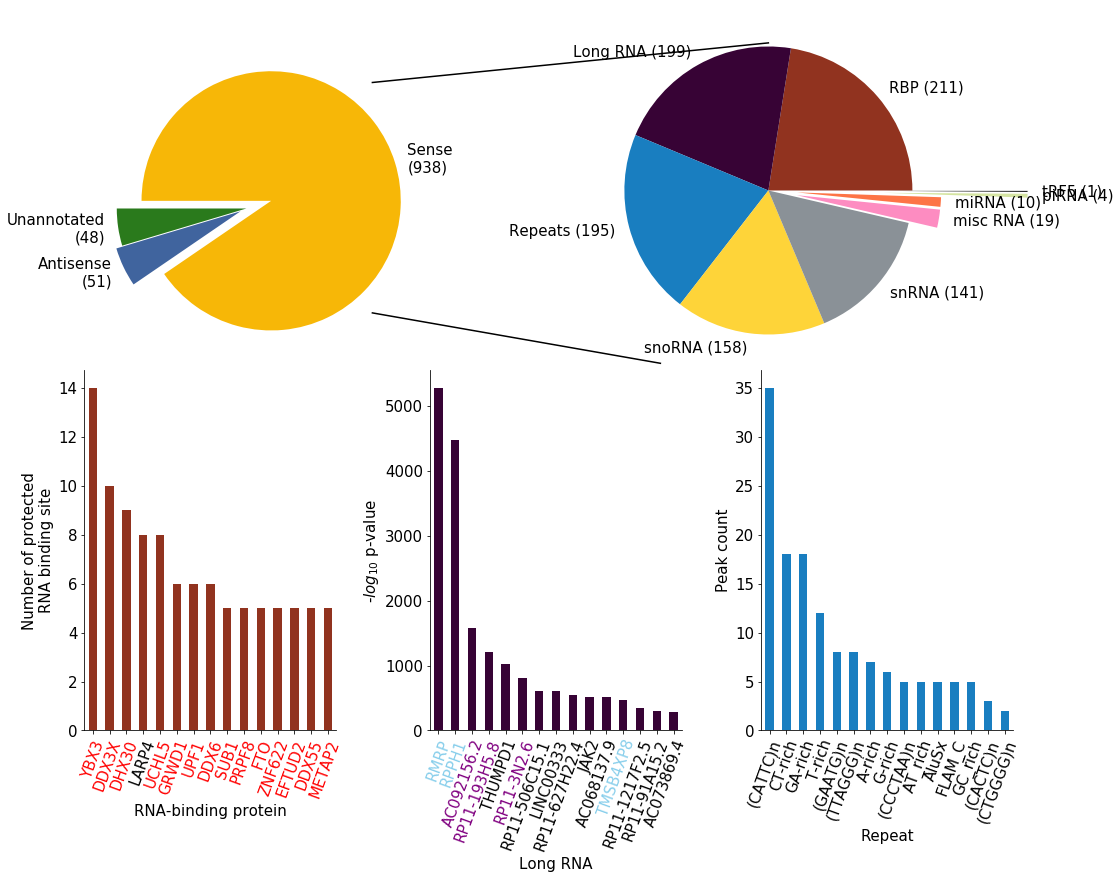

In [126]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
l1 = mlines.Line2D([0.3,0.85],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.7],[0.58,0.51], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [73]:
import RNA 

rbp = peak_df\
    .query('sense_gtype=="Long RNA"') \
    .query('pileup >= %i & sample_count >= %i'%(pileup_cutoff, sample_cutoff))\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(mt = lambda d: d.seq.map(is_mt))  \
    .assign(shape = lambda d: d.seq.map(RNA.fold))\
    .assign(energy = lambda d: list(map(lambda x: x[1], d['shape'])))\
    .assign(shape = lambda d: list(map(lambda x: x[0], d['shape'])))\
    .assign(width = lambda d: d.end - d.start)\
    .sort_values('log10p', ascending=False)
rbp.head(15)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
12,chr9,35657742,35658018,unfragmented.rvs_peak_21459,45607,1078.74915,4567.49023,4560.78662,1113.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,CGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGAC...,not_MT,...(((.((((((((((.(((((....(((((........(((((....,-103.900002,276
15,chr14,20811226,20811574,unfragmented.rvs_peak_6094,38983,962.66785,3904.95923,3898.39575,1012.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TCCCATAGGGCGGAGGGAAGCTCATCAGTGGGGCCACGAGCTGAGT...,not_MT,.......((((((((((((((((....(((....))))))))((((...,-166.100006,348
21,chr2,140977935,140978004,unfragmented.rvs_peak_11840,21664,511.72336,2172.87769,2166.49268,517.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTT...,not_MT,.((((.((..((((...))))...(((......))).......(.....,-9.800000,69
28,chr9,95301666,95301808,unfragmented.fwd_peak_22401,10183,259.76184,1024.66833,1018.36090,262.0,11,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TAGATTGAAGCCAGTTGATTAGGGTATTTAGCTGTTAACTACATTT...,not_MT,..(((((((((.(((((((((....(((.(((((....((((.......,-32.099998,142
49,chr7,63571925,63571997,unfragmented.rvs_peak_19427,5475,150.03883,553.44427,547.50531,151.0,13,...,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,72
52,chr4,91759633,91760266,unfragmented.rvs_peak_15996,4987,137.31573,504.66000,498.75940,138.0,13,...,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense,GACAACTCGGTGGTGGCCACTGCGCAGACCAGACTTCGCTCGTACT...,not_MT,.......((((((...)))))).(((..(((.....(((.((.......,-160.899994,633
55,chr1,181391920,181392117,unfragmented.fwd_peak_1604,4750,135.69624,481.12512,475.09064,137.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TATAGTTTAACCAAAACATTAGATTGTGAATCTAACAATAGAAGCC...,not_MT,((((((((((........))))))))))............((((((...,-35.700001,197
56,chr2,131029982,131030053,unfragmented.fwd_peak_12076,4721,141.12009,478.22864,472.19611,144.0,10,...,nmt-tRNA-Gln-TTG-7-1-tRF3,tRF3,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCAGGCCCATATCCCAAAAATG...,not_MT,.((((.((..((((.....))))....((((.((((.......)))...,-8.600000,71
59,chr1,238105789,238105861,unfragmented.rvs_peak_2030,4234,127.66264,429.26782,423.43698,130.0,8,...,nmt-tRNA-Pro-TGG-1-1-tRF5,tRF5,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCAGGCCCATACCCCAAAACTG...,not_MT,..(((.((((((((.....))))....))))..))).((((........,-9.000000,72
80,chr9,94872791,94872858,unfragmented.fwd_peak_22396,2394,72.99653,245.29840,239.46759,73.0,10,...,SPTLC1,Long RNA,5.030371e-246,2.319248e-243,Sense,AACTGGTAAATAGTTTAAATTAAATGATTTCGACTCATTAGATTAT...,not_MT,...((((((((((((((((((.(((((.......))))).)))).....,-13.300000,67


In [106]:
rbp.query('sense_gname == "RP11-958N24.1"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
184,chr16,15027133,15027223,unfragmented.fwd_peak_7928,710,29.01481,76.51092,71.08939,29.0,11,...,.,Unannotated,3.083756e-77,6.503130e-75,Sense,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,not_MT,(.(((.((.(.((((((.(((.(((.......)))))).))))))....,-35.5,90


In [80]:
fold = rbp.nlargest(15,'log10p').pipe(lambda d: d[~d.sense_gname.str.contains('RMRP|RPPH1|AC019188.1|HIST')])
fold

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
21,chr2,140977935,140978004,unfragmented.rvs_peak_11840,21664,511.72336,2172.87769,2166.49268,517.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTT...,not_MT,.((((.((..((((...))))...(((......))).......(.....,-9.800000,69
28,chr9,95301666,95301808,unfragmented.fwd_peak_22401,10183,259.76184,1024.66833,1018.36090,262.0,11,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TAGATTGAAGCCAGTTGATTAGGGTATTTAGCTGTTAACTACATTT...,not_MT,..(((((((((.(((((((((....(((.(((((....((((.......,-32.099998,142
49,chr7,63571925,63571997,unfragmented.rvs_peak_19427,5475,150.03883,553.44427,547.50531,151.0,13,...,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,72
55,chr1,181391920,181392117,unfragmented.fwd_peak_1604,4750,135.69624,481.12512,475.09064,137.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TATAGTTTAACCAAAACATTAGATTGTGAATCTAACAATAGAAGCC...,not_MT,((((((((((........))))))))))............((((((...,-35.700001,197
56,chr2,131029982,131030053,unfragmented.fwd_peak_12076,4721,141.12009,478.22864,472.19611,144.0,10,...,nmt-tRNA-Gln-TTG-7-1-tRF3,tRF3,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCAGGCCCATATCCCAAAAATG...,not_MT,.((((.((..((((.....))))....((((.((((.......)))...,-8.600000,71
59,chr1,238105789,238105861,unfragmented.rvs_peak_2030,4234,127.66264,429.26782,423.43698,130.0,8,...,nmt-tRNA-Pro-TGG-1-1-tRF5,tRF5,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCAGGCCCATACCCCAAAACTG...,not_MT,..(((.((((((((.....))))....))))..))).((((........,-9.000000,72
80,chr9,94872791,94872858,unfragmented.fwd_peak_22396,2394,72.99653,245.29840,239.46759,73.0,10,...,SPTLC1,Long RNA,5.030371e-246,2.319248e-243,Sense,AACTGGTAAATAGTTTAAATTAAATGATTTCGACTCATTAGATTAT...,not_MT,...((((((((((((((((((.(((((.......))))).)))).....,-13.300000,67
84,chr16,20733602,20733722,unfragmented.rvs_peak_7853,2224,73.08930,228.10538,222.46870,74.0,13,...,SFPQ,RBP,7.845489e-229,3.448129e-226,Sense,GAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTCAA...,not_MT,.....(((((((.(((...(((((((....)))))))........(...,-21.299999,120
85,chr7,57257214,57257286,unfragmented.fwd_peak_20050,2181,68.83143,223.99475,218.18591,69.0,9,...,.,Unannotated,1.012162e-224,4.407309e-222,Sense,ATAAGATATTAGTAAAATTATTTCATAACTTTGTCAAAGTTAAGTT...,not_MT,.(((((((((((.....((((..(.(((((((...))))))).).....,-10.600000,72
88,chr10,101817567,101817659,unfragmented.rvs_peak_2874,2033,65.71162,208.97951,203.36159,66.0,8,...,.,Unannotated,1.048311e-209,4.401688e-207,Sense,TCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGACTAA...,not_MT,(((((((((.(((.....)))......((((......))))....(...,-16.400000,92


In [110]:
import random
from collections import Counter
from scipy.stats import ranksums

es = []
bases = list('ACTG')
for w, seq in zip(fold.width, fold.seq):
    b = Counter(seq.upper())
    weights = [b[n] for n in bases]
    for i in range(40):
        random_seq = ''.join(random.choices(list('ACTG'), 
                                            k=w, weights=weights))
        s, e = RNA.fold(random_seq)
        es.append(e)

In [111]:
w, p = ranksums(es, fold.energy.values)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


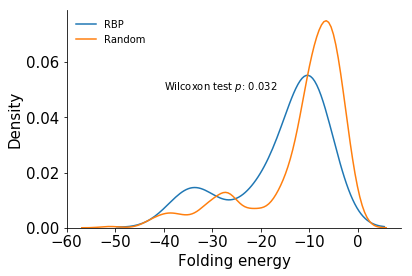

In [112]:
ax = plt.subplot()
sns.distplot(fold.energy, label = 'RBP', ax = ax, hist=False)
sns.distplot(es, label = 'Random', ax = ax, hist=False)
ax.text(-40,0.05, 'Wilcoxon test $p$: %.3f' %p)
ax.legend(frameon=False)
sns.despine()
ax.set_xlabel('Folding energy')
ax.set_ylabel('Density')
plt.savefig(figure_path + '/fold_energy.pdf', bbox_inches='tight')

In [56]:
colnames = rbp.columns.tolist()
colnames.extend(['tRNA_chrom','tRNA_start','tRNA_end','tRNA_name', 
                'tRNA_score','tRNA_strand', 'tRNA_type',
               'tRNA_id','distance'])

closest = BedTool().from_dataframe(rbp.sort_values(['chrom','start','end']))\
    .closest(b = '/stor/work/Lambowitz/ref/hg19/new_genes/tRNA.sorted.bed', d= True) \
    .to_dataframe(names = colnames) 

In [70]:
'|'.join(closest.nlargest(20, 'log10p').query('distance < 100').sense_gname)

'AC092156.2|CENPP|RP11-3N2.6|AC068137.4|RP11-193H5.8|RP11-1217F2.24|AC073869.8'

In [28]:
RNA.fold(rbp.seq.values[2])

['.((((.((..((((...))))...(((......))).......(..((......))..))).))))...',
 -9.800000190734863]

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


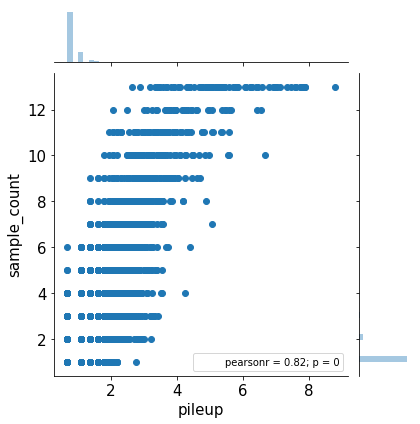

In [8]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [9]:
','.join(rbp_df.head(15).index)

'UCHL5,LARP4,DHX30,EFTUD2,YBX3,XPO5,DDX6,METAP2,SND1,SRSF7,MTPAP,PCBP2,SUB1,EIF3D,TIA1'

In [10]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


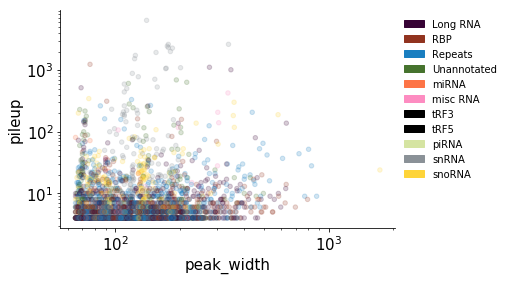

In [11]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


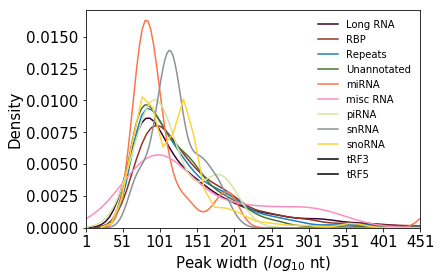

In [12]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
anti_peaks.antisense_gtype.unique()

In [ ]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [ ]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

In [ ]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

In [ ]:
intron_df \
    .query('pileup >= 5' )

In [ ]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

In [ ]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d

In [ ]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [ ]:
print(next(aln))

In [ ]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [ ]:
anti = peak_df.query('pileup >= 5').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

In [ ]:
peak_df.query("sense_gtype == 'tRF3'")